In [1]:
!{os.sys.executable} -m pip install gymnasium
!{os.sys.executable} -m pip install Pillow
!{os.sys.executable} -m pip install ipython
!{os.sys.executable} -m pip install pygame
!{os.sys.executable} -m pip install torchsummary
!{os.sys.executable} -m pip install tensorboardX

zsh:1: parse error near `-m'
zsh:1: parse error near `-m'
zsh:1: parse error near `-m'
zsh:1: parse error near `-m'
zsh:1: parse error near `-m'
zsh:1: parse error near `-m'


In [2]:
# Import useful packages

import os
import sys
import gymnasium as gym
import random
import numpy as np

import torch
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary

from DQN_Model import DQN
from DQN_Model_improved import DQN_improved
from tensorboardX import SummaryWriter

from collections import namedtuple, deque

## Configuration 

In [3]:
env_name = 'CartPole-v1'
gamma = 0.99
batch_size = 32
lr = 0.0001
initial_exploration = 1000
goal_score = 200
log_interval = 1 # 10
update_target = 100
replay_memory_capacity = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



## Memory Class

In [4]:
Transition = namedtuple(
    'Transition', ('state', 'next_state', 'action', 'reward', 'mask')
)

class Memory_DQN(object):
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
        self.capacity = capacity

    def push(self, state, next_state, action, reward, mask):
        self.memory.append(Transition(state, next_state, action, reward, mask))
    
    def sample(self, batch_size):
        transitions = random.sample(self.memory, batch_size)
        batch = Transition(*zip(*transitions))
        return batch
    
    def __len__(self):
        return len(self.memory)

## Helper Functions

In [5]:
def get_action(state, target_net, epsilon, env):
    if np.random.rand() <= epsilon:
        return env.action_space.sample() #random action
    else:
        return target_net.get_action(state)

## Train Function

In [6]:
env=gym.make(env_name)


state_size = env.observation_space.low.size
action_size = env.action_space.n

print("state_size", state_size)
print("action_size", action_size)

online_net = DQN(state_size, action_size).to(device)
target_net = DQN(state_size, action_size).to(device)
# online_net = DQN_improved(state_size, action_size).to(device)
# target_net = DQN_improved(state_size, action_size).to(device)


online_net.train()
target_net.train()
writer = SummaryWriter('logs')

summary(online_net, input_size = (batch_size, state_size)) 

optimizer = optim.Adam(online_net.parameters(), lr=lr)
N_EPISODES = 5000

#initialize running variables
running_score = 0
epsilon = 1.0
epsilon_decay_rate = 0.000005
steps = 0
loss = 0

# initialize the memory bank
memory = Memory_DQN(replay_memory_capacity)



state_size 4
action_size 2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 32, 128]             640
            Linear-2                [-1, 32, 2]             258
Total params: 898
Trainable params: 898
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [7]:
for episode in range(N_EPISODES):
    done = False

    score = 0
    state = env.reset()[0]
    state = torch.Tensor(state).to(device)

    while not done:
        steps += 1
        action = get_action(state, target_net, epsilon, env)
        next_state, reward, done, _, _ = env.step(action) # 5 outputs
        next_state = torch.Tensor(next_state).to(device)

        mask = 0 if done else 1 #don't know what this line does

        # i assume this is the penalty function?
        reward = reward if not done or score == 499 else -1

        action_one_hot = np.zeros(2)
        action_one_hot[action] = 1

        # add to memory bank
        memory.push(state, next_state, action_one_hot, reward, mask)

        score += reward
        state = next_state

        if steps > initial_exploration:
            epsilon -= epsilon_decay_rate
            epsilon = max(epsilon, 0.01)

            # process the batch
            batch = memory.sample(batch_size)
            # print("batch", batch)
            states = torch.stack(batch.state).to(device)
            next_states = torch.stack(batch.next_state).to(device)
            actions = torch.Tensor(batch.action).float().to(device)
            rewards = torch.Tensor(batch.reward).to(device)
            masks = torch.Tensor(batch.mask).to(device)

            q_values = online_net(states).gather(1, actions.long())
            next_q_values = target_net(next_states).max(1)[0].detach()

            q_target  = rewards + gamma * next_q_values*masks
            

            
            loss = F.mse_loss(q_values, q_target.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if steps % initial_exploration:
                target_net.load_state_dict(online_net.state_dict())
    score = score if score == 500.0 else score + 1
    if running_score == 0:
        running_score = score
    else:
        running_score = 0.99 * running_score + 0.01 * score
    if episode % log_interval == 0:
        print('{} episode | score: {:.2f} | loss: {:.5f} | epsilon: {:.2f}'.format(
            episode, running_score, loss, epsilon))
        writer.add_scalar('log/score', float(running_score), episode)
        writer.add_scalar('log/loss', float(loss), episode)

    if running_score > goal_score:
        break
            
            

            
            
        

0 episode | score: 18.00 | loss: 0.00000 | epsilon: 1.00
1 episode | score: 18.04 | loss: 0.00000 | epsilon: 1.00
2 episode | score: 18.11 | loss: 0.00000 | epsilon: 1.00
3 episode | score: 18.10 | loss: 0.00000 | epsilon: 1.00
4 episode | score: 18.19 | loss: 0.00000 | epsilon: 1.00
5 episode | score: 18.17 | loss: 0.00000 | epsilon: 1.00
6 episode | score: 18.11 | loss: 0.00000 | epsilon: 1.00
7 episode | score: 18.05 | loss: 0.00000 | epsilon: 1.00
8 episode | score: 17.95 | loss: 0.00000 | epsilon: 1.00
9 episode | score: 17.89 | loss: 0.00000 | epsilon: 1.00
10 episode | score: 17.95 | loss: 0.00000 | epsilon: 1.00
11 episode | score: 17.91 | loss: 0.00000 | epsilon: 1.00
12 episode | score: 17.85 | loss: 0.00000 | epsilon: 1.00
13 episode | score: 17.91 | loss: 0.00000 | epsilon: 1.00
14 episode | score: 18.06 | loss: 0.00000 | epsilon: 1.00
15 episode | score: 17.98 | loss: 0.00000 | epsilon: 1.00
16 episode | score: 18.21 | loss: 0.00000 | epsilon: 1.00
17 episode | score: 18.1

/var/folders/ns/hfpwj42x3zd2qyh387_9zcvm0000gn/T/ipykernel_27768/1717082273.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  actions = torch.Tensor(batch.action).float().to(device)
/var/folders/ns/hfpwj42x3zd2qyh387_9zcvm0000gn/T/ipykernel_27768/1717082273.py:48: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(q_values, q_target.unsqueeze(1))


61 episode | score: 19.43 | loss: 1.62362 | epsilon: 1.00
62 episode | score: 19.37 | loss: 1.62606 | epsilon: 1.00
63 episode | score: 19.31 | loss: 1.74488 | epsilon: 1.00
64 episode | score: 19.42 | loss: 1.71629 | epsilon: 1.00
65 episode | score: 19.46 | loss: 1.58050 | epsilon: 1.00
66 episode | score: 19.56 | loss: 1.97595 | epsilon: 1.00
67 episode | score: 19.54 | loss: 1.63840 | epsilon: 1.00
68 episode | score: 19.45 | loss: 1.83353 | epsilon: 1.00
69 episode | score: 19.45 | loss: 1.70207 | epsilon: 1.00
70 episode | score: 19.50 | loss: 1.80723 | epsilon: 1.00
71 episode | score: 19.53 | loss: 2.03360 | epsilon: 1.00
72 episode | score: 19.57 | loss: 1.79139 | epsilon: 1.00
73 episode | score: 19.79 | loss: 1.80155 | epsilon: 1.00
74 episode | score: 19.74 | loss: 2.73975 | epsilon: 1.00
75 episode | score: 19.64 | loss: 1.89993 | epsilon: 1.00
76 episode | score: 19.88 | loss: 1.55107 | epsilon: 1.00
77 episode | score: 20.71 | loss: 1.86159 | epsilon: 1.00
78 episode | s

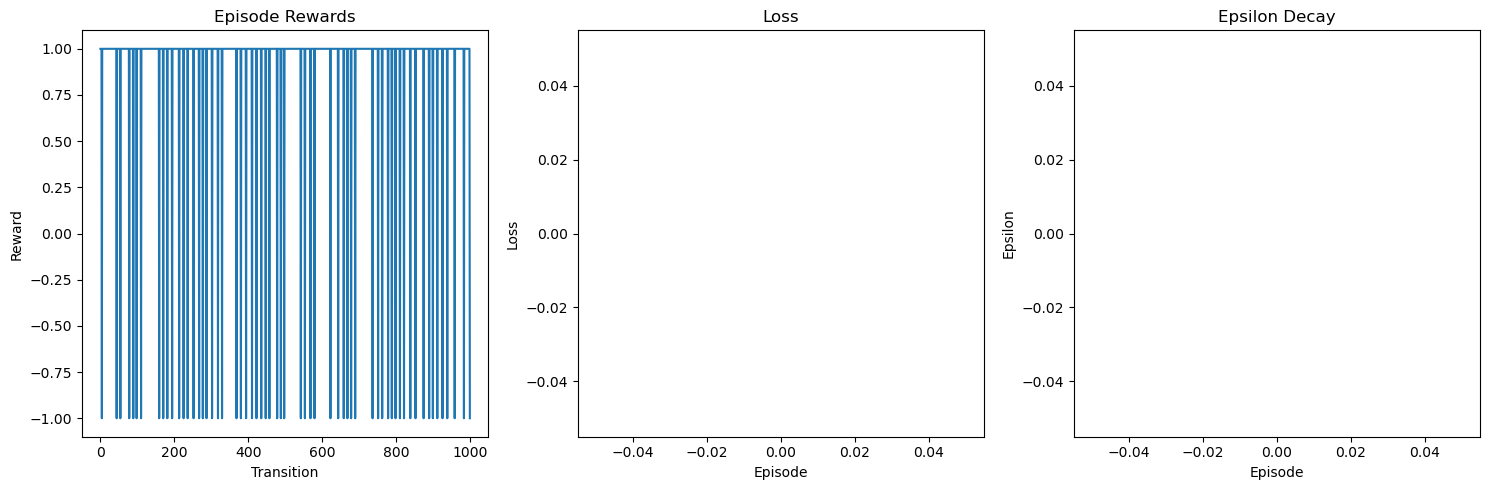

In [8]:
import matplotlib.pyplot as plt

# Extract metrics from memory.memory
rewards = [transition.reward for transition in memory.memory]
losses = []  # You should collect and store the losses during training to plot them
epsilons = []  # You should collect and store the epsilons during training to plot them

# Plotting the metrics
plt.figure(figsize=(15, 5))

# Plot Rewards
plt.subplot(1, 3, 1)
plt.plot(rewards)
plt.title('Episode Rewards')
plt.xlabel('Transition')
plt.ylabel('Reward')

# Plot Losses (assuming you have a list of losses)
plt.subplot(1, 3, 2)
plt.plot(losses)
plt.title('Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

# Plot Epsilons (assuming you have a list of epsilons)
plt.subplot(1, 3, 3)
plt.plot(epsilons)
plt.title('Epsilon Decay')
plt.xlabel('Episode')
plt.ylabel('Epsilon')

plt.tight_layout()
plt.show()
